### Coverage and log-prob $\theta^*$ plots

In [4]:
import pickle
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2

sns.set_context("paper", font_scale=1.225)
sns.set_style("whitegrid", {"font.family":"Times New Roman", "font.serif":"serif", "font.size": 11})
plt.rcParams["axes.grid"] = False

colors = ["#072D41", "#ECA918", "#60B3C8", "#359735"]

from plotnine import (
    ggplot, aes, geom_line, scale_colour_manual,
    geom_abline, element_blank,
    facet_wrap, theme_bw, theme,
    coord_fixed, element_text
    )

results_dir = "../../results"
slab_scale = 0.25
hyperprior = False
misspecified = False
hyperparam_string = f"slab_scale={slab_scale}_hyperprior={hyperprior}_misspecified={misspecified}"
num_obs = 500

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
task_names = ["Gaussian", "SIR", "CS"]
method_names = ["NPE", "RNPE"]

results = {t: [] for t in task_names}

for task in task_names:
    task_dir = f"{results_dir}/{task}/"
    for f_name in sorted(os.listdir(task_dir)):
        if f"{hyperparam_string}.pickle" in f_name:
            with open(task_dir + f_name, "rb") as f:
                res = pickle.load(f)
                results[task].append(res["metrics"])

# Only use 1000
results = {k: [v[i] for i in range(num_obs)] for k,v in results.items()}


In [6]:
df_list = []
residual_list = []

for task in task_names:
    for method in method_names:
        task_em_res = [res[method] for res in results[task]]
        metrics = {k: [res[k] for res in task_em_res] for k in ["log_prob_theta*", "hpd"]}
        metrics["Task"] = task
        metrics["Method"] = method
        df_list.append(pd.DataFrame(metrics))

        residual_list.append(
            {"Method": method, "Task": task,
            "residuals": np.row_stack([r["point_estimate_residuals"] for r in task_em_res])
            })

df = pd.concat(df_list)
df["Method"] = pd.Categorical(df["Method"], categories=["RNPE", "NPE"])
df = df.reset_index(drop=True)


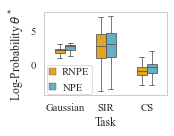

In [7]:
palette = {"RNPE": colors[1], "NPE": colors[2]}

fig = plt.figure()
fig.set_size_inches(5.5*(2/5), 1.51, forward=True)

p = sns.boxplot(
    x = "Task",
    y = "log_prob_theta*",
    hue = "Method",
    showfliers=False,
    width=0.5,
    data=df,
    palette=palette,
    saturation=0.9,
    linewidth=0.75)

plt.ylabel(r"Log-Probability $\theta^*$")
handles, labels = p.get_legend_handles_labels() # Remove legend title
p.legend(
    handles=handles,
    labels=labels,
    borderpad=0.2,
    bbox_to_anchor=(.43, .43),
    handletextpad=-0.75
    )

for lh in p.legend_.legendHandles:
    lh.set_width(7)
    lh.set_height(7)

plt.savefig(f"{results_dir}/plots/log_prob_theta_true_{hyperparam_string}.pdf", bbox_inches="tight", dpi=300)

## Coverage plot

In [8]:
import numpy as np

confidence_level = np.linspace(0, 1, 1001)

cov_df_list = []
for task in task_names:
    for method in method_names:
        coverage = []
        for level in confidence_level:
            hpd_subset = df["hpd"][(df["Task"] == task) & (df["Method"] == method)]
            coverage.append(sum(hpd_subset/100 <= level)/len(hpd_subset))
        
        cov_df_list.append(
            pd.DataFrame({
                "Confidence Level": confidence_level,
                "Empirical Coverage": coverage,
                "Task": task,
                "Method": method
            })
        )
cov_df = pd.concat(cov_df_list)
cov_df = cov_df.reset_index(drop=True)
cov_df = cov_df.drop_duplicates(subset=["Empirical Coverage", "Task", "Method"])
cov_df["Method"] = pd.Categorical(cov_df["Method"], categories=["RNPE", "NPE"])
cov_df["Task"] = pd.Categorical(cov_df["Task"], categories=task_names)


/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3.3 x 2 in image.
/home/dw16200/miniconda3/envs/rnpe_env/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ../../results/plots/coverage_slab_scale=0.25_hyperprior=False_misspecified=False.pdf


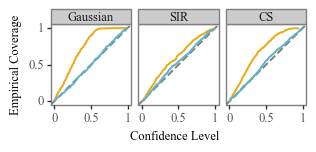

<ggplot: (8764704482320)>

In [9]:
from plotnine import scale_x_continuous, scale_y_continuous, element_blank
font_kwargs = {"family": "Times New Roman", "size": 9}
txt = element_text(**font_kwargs)
line_size = 0.8
cov_p = (
    ggplot(cov_df, aes(x="Confidence Level", y="Empirical Coverage", colour="Method")) +
    facet_wrap("~Task", nrow=1) +
    geom_abline(slope=1, intercept=0, size=line_size, linetype="dashed", color="grey") +
    geom_line(size=line_size) +
    scale_colour_manual(values=palette, guide=False) +
    theme_bw() +
    coord_fixed() +
    scale_x_continuous(breaks=[0, 0.5, 1]) +
    scale_y_continuous(breaks=[0, 0.5, 1]) +
    theme(
        strip_text_x = element_text(
            margin={"t": 7, "b": 5}),
        text=txt, title=txt, axis_title=txt, strip_text=txt,
        figure_size=(5.5*(3/5), 2),
        panel_grid_minor=element_blank(),
        panel_grid_major=element_blank()
    )
)
cov_p.save(f"{results_dir}/plots/coverage_{hyperparam_string}.pdf", dpi=600)
cov_p


### Calculate residual

In [10]:
from rnpe.tasks import Gaussian, SIR, CS
residual_df_list = []
for r in residual_list:
    task_name = r["Task"]
    task = {"Gaussian": Gaussian(), "SIR": SIR(), "CS": CS()}[task_name]
    names = np.array(task.theta_names)
    n = r["residuals"].shape[0]
    r["Residuals"] = r["residuals"].flatten("F")
    r["Parameter"] = names.repeat(n)

    residual_df_list.append(pd.DataFrame(
        {k: r[k] for k in ["Residuals", "Parameter", "Task", "Method"]}
    ))
residual_df = pd.concat(residual_df_list)

In [11]:
residual_df["Squared Residuals"] = residual_df["Residuals"]**2

In [12]:
residual = residual_df.groupby(["Task", "Method", "Parameter"])["Squared Residuals"].mean()
residual = residual.reset_index()
residual = residual.pivot(columns=["Method"], index=["Task", "Parameter"])
residual.to_csv(f"{results_dir}/residual.csv", float_format="%.2f")
residual

Squared Residuals          
Method                             NPE      RNPE
Task     Parameter                              
CS       $\lambda_c$          0.126438  0.132391
         $\lambda_d$          1.906356  1.216539
         $\lambda_p$          1.103633  0.752109
Gaussian $\mu$                0.162822  0.021351
SIR      $\beta$              1.159769  0.138410
         $\gamma$             0.624818  0.111467